In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# !pip install tensorflow==1.13.1
# !pip install keras==2.2.4

In [12]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline


In [13]:
def conll_sentences(conll_file):
    sent = []
    pos = []
    chunk = []
    entity = []
    temp_sent = []
    temp_pos = []
    temp_chunk = []
    temp_entity = []
    
    with open(conll_file) as f:
        conll_raw_data = f.readlines()
    conll_raw_data = [x.strip() for x in conll_raw_data]

    for line in conll_raw_data:
        if line != '':
            split_line = line.split()
            if len(split_line) == 4:
                if split_line[0] != '-DOCSTART-':
                    temp_sent.append(split_line[0])
                    temp_pos.append(split_line[1])
                    temp_chunk.append(split_line[2])
                    
                    # Rename entity values as PER, LOC, ORG, MISC, O
                    old_ent = split_line[3]
                    if old_ent in ('I-ORG', 'B-ORG'):
                        new_ent = 'ORG'
                    elif old_ent in ('I-LOC', 'B-LOC'):
                        new_ent = 'LOC'
                    elif old_ent in ('I-MISC', 'B-MISC'):
                        new_ent = 'MISC'
                    elif old_ent in ('I-PER', 'B-PER'):
                        new_ent = 'PER'
                    else:
                        new_ent = 'O'
                    temp_entity.append(new_ent)
            else:
                raise IndexError('Line split length does not equal 4.')
        else:
            if len(temp_sent) > 0:
                assert(len(sent) == len(pos))
                assert(len(sent) == len(chunk))
                assert(len(sent) == len(entity))
                sent.append(temp_sent)
                pos.append(temp_pos)
                chunk.append(temp_chunk)
                entity.append(temp_entity)
                temp_sent = []
                temp_pos = []
                temp_chunk = []
                temp_entity = []
    
    return sent, pos, chunk, entity

In [14]:
train_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.train"
testa_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.testa"
testb_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.testb"
testc_file = r"/content/drive/MyDrive/Dataset/NER_Dataset/CoNLL2003/eng.testc"

train_sentence, train_pos, train_chunk, train_entity = conll_sentences(train_file)
testa_sentence, testa_pos, testa_chunk, testa_entity = conll_sentences(testa_file)
testb_sentence, testb_pos, testb_chunk, testb_entity = conll_sentences(testb_file)
testc_sentence, testc_pos, testc_chunk, testc_entity = conll_sentences(testc_file)

In [15]:
max_len = max([len(x) for x in train_sentence])
max_len

113

In [16]:
entites = []
for line in train_entity:
  for e in line:
    entites.append(e)

entites_set = set(entites)
tag2idx = {t: i for i, t in enumerate(entites_set)}
tag2idx

{'O': 0, 'ORG': 1, 'LOC': 2, 'PER': 3, 'MISC': 4}

In [17]:
combined_words = set()
for line in train_sentence + testa_sentence + testb_sentence + testc_sentence:
  for w in line:
    combined_words.add(w)

combined_words.add("ENDPAD")

word2idx = {w: i + 1 for i, w in enumerate(combined_words)}

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sentence_word2idx(sentences):
  X = [[word2idx[w] for w in s] for s in sentences]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(word2idx)-1)
  return X


In [19]:
train_sentence = get_sentence_word2idx(train_sentence)
testa_sentence = get_sentence_word2idx(testa_sentence)
testb_sentence = get_sentence_word2idx(testb_sentence)
testc_sentence = get_sentence_word2idx(testc_sentence)

In [20]:
from tensorflow.keras.utils import to_categorical

def get_sentence_tag2idx(n_entites, entites):
  y = [[tag2idx[w] for w in s] for s in entites]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  y = [to_categorical(i, num_classes=n_entites) for i in y]
  return np.array(y)


In [21]:
train_entity = get_sentence_tag2idx(len(tag2idx), train_entity)
testa_entity = get_sentence_tag2idx(len(tag2idx), testa_entity)
testb_entity = get_sentence_tag2idx(len(tag2idx), testb_entity)
testc_entity = get_sentence_tag2idx(len(tag2idx), testc_entity)

In [22]:
max_features = len(word2idx)+1

In [23]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-0206powd
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-0206powd


In [27]:
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

def build_model():
  model = Sequential()
  model.add(Embedding(input_dim=max_features, output_dim=200, input_length=max_len))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
  model.add(TimeDistributed(Dense(len(tag2idx), activation="relu")))
  crf_layer = CRF(len(tag2idx))
  model.add(crf_layer)

  model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_accuracy])
  model.summary()

  return model

In [28]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 113, 200)          6058200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 113, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 113, 256)          336896    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 113, 5)            1285      
_________________________________________________________________
crf_2 (CRF)                  (None, 113, 5)            65        
Total params: 6,396,446
Trainable params: 6,396,446
Non-trainable params: 0
_________________________________________________________________


In [33]:
BATCH_SIZE = 128
EPOCHS = 10

In [34]:
history = model.fit(train_sentence, train_entity,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=[testa_sentence, testa_entity],
                    verbose=1)

Train on 14041 samples, validate on 3250 samples
Epoch 1/10
14041/14041 [==============================] - 207s 15ms/step - loss: 0.0833 - crf_accuracy: 0.9785 - val_loss: 0.0785 - val_crf_accuracy: 0.9766
Epoch 2/10
14041/14041 [==============================] - 200s 14ms/step - loss: 0.0569 - crf_accuracy: 0.9806 - val_loss: 0.0528 - val_crf_accuracy: 0.9822
Epoch 3/10
14041/14041 [==============================] - 177s 13ms/step - loss: 0.0399 - crf_accuracy: 0.9856 - val_loss: 0.0457 - val_crf_accuracy: 0.9830
Epoch 4/10
14041/14041 [==============================] - 175s 12ms/step - loss: 0.0333 - crf_accuracy: 0.9868 - val_loss: 0.0415 - val_crf_accuracy: 0.9840
Epoch 5/10
14041/14041 [==============================] - 175s 12ms/step - loss: 0.0289 - crf_accuracy: 0.9896 - val_loss: 0.0375 - val_crf_accuracy: 0.9875
Epoch 6/10
14041/14041 [==============================] - 176s 13ms/step - loss: 0.0240 - crf_accuracy: 0.9917 - val_loss: 0.0336 - val_crf_accuracy: 0.9885
Epoch 7/1

In [35]:
import pandas as pd

hist = pd.DataFrame(history.history)

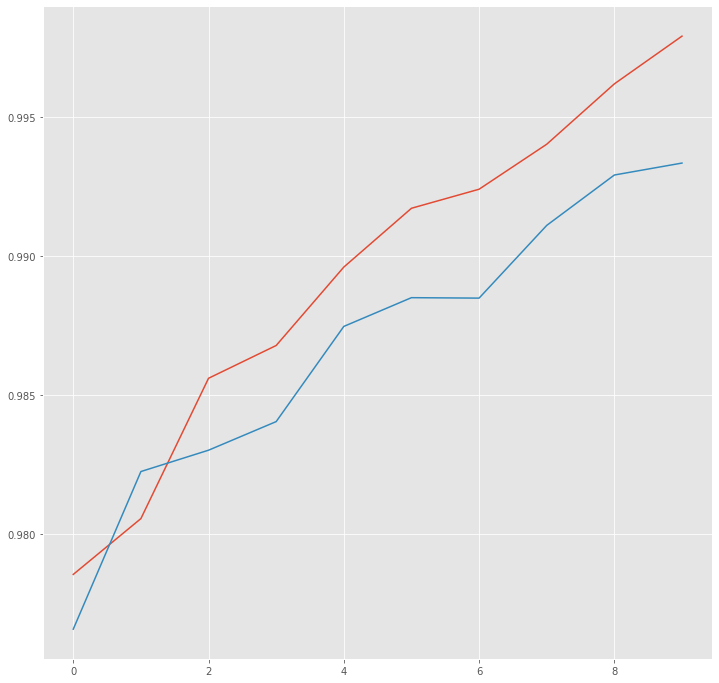

In [39]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_accuracy"])
plt.plot(hist["val_crf_accuracy"])
plt.show()

In [41]:
model.save_weights("/content/bilstm_crf_best_model_weights.h5")

In [43]:
model.evaluate(testb_sentence, testb_entity)

3453/3453 [==============================] - 16s 5ms/step


[0.032792901552840314, 0.991696333785075]